In [1]:
import os
import nibabel as nib
import numpy as np
from nibabel.testing import data_path
import pyopenvdb as vdb
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from functions import parent_directory, normalize_array, show_3D_array, create_volume
import copy

In [2]:
#Set up output folders
parent_directory = parent_directory()

In [3]:
anat_filepath = "/workspaces/neurovolume/media/sub-01/anat/sub-01_T2w.nii.gz"

anat_norm = create_volume(normalize_array(nib.load(anat_filepath).get_fdata()))


In [4]:
#copypasta from matplotlib docs
def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            layout='constrained', squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

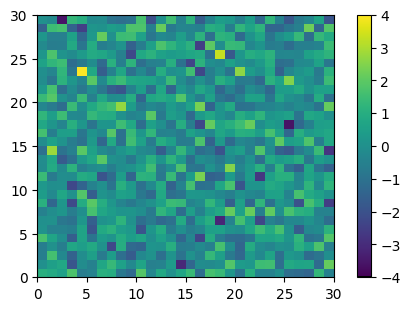

In [5]:
#TODO custom color scheme here to explicitly show zero values
norm_viridis = mpl.colormaps['viridis'].resampled(256) # TODO check if your anat_norm is 8-bit float?
newcolors = norm_viridis(np.linspace(0,1,256))
black = np.array([0,0,0,1])
newcolors[:1,:] = black
black_zero = ListedColormap(newcolors)

plot_examples([black_zero])

mpl.colormaps.register(cmap=black_zero)

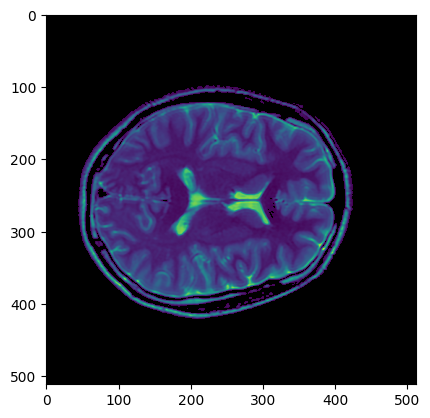

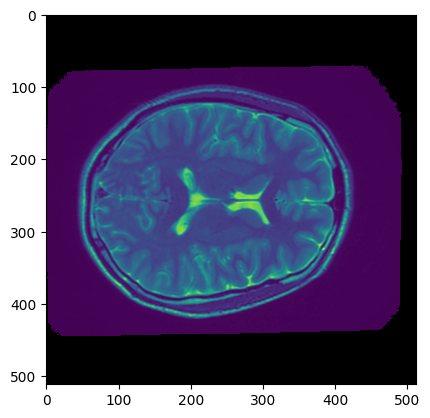

In [6]:
clipped_anat_norm = copy.deepcopy(anat_norm)
np.clip(clipped_anat_norm, 0.1, 1.0, clipped_anat_norm)

mid = int(clipped_anat_norm.shape[2]/2)

plt.set_cmap(black_zero)
plt.imshow(clipped_anat_norm[:,:,mid])
plt.show()
plt.imshow(anat_norm[:,:,mid])
plt.show()


In [ ]:
transform_matrix = [
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0]
]
#is there a better way than hard coding an identity matrix index by index?

In [ ]:
grid = vdb.FloatGrid() #DoubleGrid no longer avail?
grid.copyFromArray(anat_norm.astype(float))
grid.transform = vdb.createLinearTransform(transform_matrix)
grid.gridClass = vdb.GridClass.FOG_VOLUME
grid.name='density'

In [ ]:
output_path = os.path.join(parent_directory, "output/", "sub01_anat.vdb")

In [ ]:
vdb.write(output_path, grid)

# Docker copy commands
`docker cp 4ba02c34fa159f23009802e83ead97b06e98831bd1b14e2dc843c901b367694e:/workspaces/neurovolume/output/sub01_anat.vdb ./sub01_anat.vdb`


`docker cp 4ba02c34fa159f23009802e83ead97b06e98831bd1b14e2dc843c901b367694e:/workspaces/neurovolume/output/numpy_test.npy ./numpy_test.npy`

In [ ]:
npy_output_path = os.path.join(parent_directory, "output/numpy_test.npy")
np.save(npy_output_path, anat_norm)

# Conclusion
- Both directly saving out the npy file as well as the generated vdb here show up pretty foggy in blender.
- Could this be **due to the lack of `DoubleGrid`**? Doesn't seem so as the npy file also is borked
- Is there a way to debug this further?
- Looking closely at the slice, it appears that there is an ever so slight brightness around the skull (makes sense for the VDB)